Dataset : https://www.kaggle.com/datasets/mssmartypants/rice-type-classification

using --quiet to hide some pip output, it no longer elaborates on which specific packages are conflicting

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abhishikththul9
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 87.9MB/s]

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [4]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis = 1, inplace=True)
print(data_df.shape)

(18185, 11)


In [5]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [6]:
print(data_df["Class"].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [7]:
original_df = data_df.copy()

for column in data_df.columns:
    data_df[column] = data_df[column] / data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [8]:
# all values except the last column
X = np.array(data_df.iloc[:, :-1])
# only the last column (i.e., Class)
Y = np.array(data_df.iloc[:, -1])

In [9]:
# train, validation, test - Splitting of the dataset
# 70% split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [10]:
# 50-50 split for the validattion and testing
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [11]:
# so finally, 70% training, 15% validation, 15% testing
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [12]:
# we will create a pytorch dataset object so we can use that with pytorch
# so we have to tell pytorch how to access or dataset

# torch understands tensors - like a list, vector or a matrix

class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]



In [13]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [14]:
# Data Loader
# go through the data by batch size (small groups of batches)
# to loop though each epoch

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=32, shuffle=True)

In [15]:
# this is just to check how the batch works
# for x there will be 8 rows
# for y there will be 8 columns

for x, y in train_dataloader:
    print(x)
    print("=====")
    print(y)
    break

tensor([[0.6420, 0.8984, 0.6281, 0.9817, 0.6130, 0.8013, 0.8057, 0.7132, 0.6921,
         0.8115],
        [0.7957, 0.8512, 0.8102, 0.9344, 0.7588, 0.8920, 0.8638, 0.7265, 0.8267,
         0.5960],
        [0.5088, 0.7660, 0.5819, 0.9719, 0.4900, 0.7133, 0.6056, 0.6320, 0.6986,
         0.7469],
        [0.7662, 0.7893, 0.8524, 0.9036, 0.7300, 0.8753, 0.8827, 0.6966, 0.8659,
         0.5253],
        [0.6724, 0.7294, 0.8063, 0.8969, 0.6424, 0.8200, 0.8312, 0.6457, 0.8844,
         0.5132],
        [0.4174, 0.6197, 0.5848, 0.9362, 0.3956, 0.6461, 0.7335, 0.5214, 0.8421,
         0.6011],
        [0.5961, 0.8153, 0.6466, 0.9661, 0.5670, 0.7721, 0.8801, 0.6640, 0.7414,
         0.7153],
        [0.9039, 0.8957, 0.8769, 0.9283, 0.8596, 0.9507, 0.6670, 0.7697, 0.8368,
         0.5795],
        [0.5703, 0.8203, 0.6169, 0.9732, 0.5465, 0.7552, 0.6248, 0.6656, 0.7060,
         0.7544],
        [0.4528, 0.5832, 0.6819, 0.8792, 0.4288, 0.6729, 0.8901, 0.5204, 0.9168,
         0.4852],
        [0

In [25]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # layers - forward propogation
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model = MyModel().to(device)

In [26]:
summary(model, (X.shape[1], ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [27]:
# Loss Function and optimizers
# BCE = Binary Cross Entropy

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

In [28]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10
for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for data in train_dataloader:
        inputs, labels = data

        # before squeeze torch.Size([8, 1])
        prediction = model(inputs).squeeze(1)
        # after squeeze torch.Size([8])

        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()

        # .sum() ==> this will return a tensor having the total number of True values
        # .item() ==> this will return an integer number of the total number of True values
        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        # backward propogation
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()
            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))

    total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
    total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__() * 100, 4))

    print(f"""Epoch No. {epoch + 1} Train Loss : {round(total_loss_train/1000, 4)} Train Accuracy : {round(total_acc_train/training_data.__len__() * 100, 4)}
              Validation Loss : {round(total_loss_val/1000, 4)} Validation Accuracy : {round(total_acc_val/validation_data.__len__() * 100, 4)}""")


    print("=" * 80)

Epoch No. 1 Train Loss : 0.2318 Train Accuracy : 86.299
              Validation Loss : 0.0358 Validation Accuracy : 98.2038
Epoch No. 2 Train Loss : 0.1071 Train Accuracy : 97.9496
              Validation Loss : 0.0143 Validation Accuracy : 98.2038
Epoch No. 3 Train Loss : 0.0507 Train Accuracy : 98.2795
              Validation Loss : 0.0086 Validation Accuracy : 98.1672
Epoch No. 4 Train Loss : 0.0336 Train Accuracy : 98.4602
              Validation Loss : 0.0063 Validation Accuracy : 98.3504
Epoch No. 5 Train Loss : 0.0266 Train Accuracy : 98.5466
              Validation Loss : 0.0052 Validation Accuracy : 98.5704
Epoch No. 6 Train Loss : 0.0228 Train Accuracy : 98.4759
              Validation Loss : 0.0048 Validation Accuracy : 98.5704
Epoch No. 7 Train Loss : 0.0208 Train Accuracy : 98.6095
              Validation Loss : 0.0045 Validation Accuracy : 98.5337
Epoch No. 8 Train Loss : 0.0194 Train Accuracy : 98.5938
              Validation Loss : 0.0044 Validation Accuracy : 9

In [29]:
# Testing
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for data in testing_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        bactch_loss_test = criterion(prediction, labels).item()
        total_loss_test += bactch_loss_test

        acc = ((prediction).round() == labels).sum().item()

        total_acc_test += acc

print(f"Accuracy {round(total_acc_test/testing_data.__len__() * 100, 4)}")

Accuracy 98.937


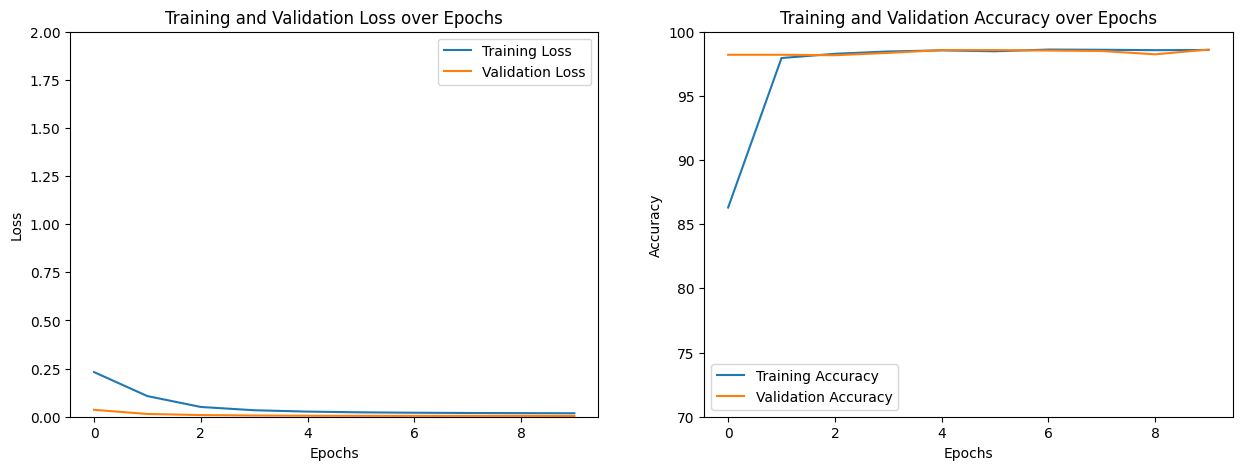

In [31]:
# Visualization
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([70, 100])
axs[1].legend()

plt.show()

In [32]:
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))

Area: 6431.279
Major Axis Length: 145.21338
Minor Axis Length: 56.902
Eccentricity: 0.919981821
Convex Area: 6518.93759999
EquivDiameter: 90.483541
Extent: 0.8506668
Perimeter: 329.972
Roundness: 0.742255516
AspectRation: 2.551696
tensor([0.7845], device='cuda:0', grad_fn=<SigmoidBackward0>)
Class is:  1


In [ ]:
'''
Area: 6431.279
Major Axis Length: 145.21338
Minor Axis Length: 56.902
Eccentricity: 0.919981821
Convex Area: 6518.93759999
EquivDiameter: 90.483541
Extent: 0.8506668
Perimeter: 329.972
Roundness: 0.742255516
AspectRation: 2.551696
====================
tensor([0.7845], device='cuda:0', grad_fn=<SigmoidBackward0>)
Class is:  1
'''